# Сегментация тетрадей

## Detectron2 baseline

В данном ноутбуке представлен baseline модели сегментации текста в школьных тетрадях с помощью фреймворка detectron2. Вы можете (и это даже лучше) использовать другие модели (например UNET, mmdet), или написать полностью свою.

# 0. Установка библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [16]:
!pip3 install torch==1.10.2+cu102 torchvision==0.11.3+cu102 torchaudio===0.10.2+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu102/torch-1.10.2%2Bcu102-cp37-cp37m-linux_x86_64.whl (881.9 MB)
  Using cached https://download.pytorch.org/whl/cu102/torchvision-0.11.3%2Bcu102-cp37-cp37m-linux_x86_64.whl (23.2 MB)
  Using cached https://download.pytorch.org/whl/cu102/torchaudio-0.10.2%2Bcu102-cp37-cp37m-linux_x86_64.whl (2.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [17]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [18]:
!pip install tensorflow==2.1.0

In [19]:
!pip install opencv-python

## 1. Загрузить необходимые библиотеки для создания и обучения модели

In [20]:
import cv2
import random
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

In [21]:
import tqdm

In [22]:
from matplotlib import pyplot as plt

In [23]:
import numpy as np

In [24]:
import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [25]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


# 2. Валидационный датасет

Для валидации наших моделей нам неплохо было создать из обучающих данных валидационный датасет. Для этого разделим наш датасет на две части - для обучения и для валидации. Для этого просто создадим два новых файлика с аннотациями, куда раздельно запишем исиходную информацию об аннотациях.

# 3. Регистрация датасета

Зарегистрируем выборки в detectron2 для дальнейшей подачи на обучение модели.

In [26]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("train_segmentation/annotations_{}.json".format(d),
    image_root= "train_segmentation/images",\
    dataset_name="my_dataset_"+d,extra_annotation_keys=['bbox_mode']))

После регистрации можно загружать выборки, чтобы иметь возможность посмотреть на них глазами. Первой загрузим обучающую выборку в **dataset_dicts_train**

In [27]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

И тестовую выборку в **dataset_dicts_val**

In [28]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

Посмотрим на размер получившихся выборок - эта операция в python осуществляется при помощи функции **len()**

In [29]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 745
Размер тестовой выборки (Картинки): 187


Итак, у нас в распоряжении 588 изображения для тренировки, и 66 - для проверки качества.

**Посмотрим на размеченные фотографии из валидации**

In [30]:
import os
from IPython.display import Image
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

##   4 Обучение модели

**4.1. Определяем конфигурацию**

Прежде чем начать работать с самой моделью, нам нужно определить ее параметры и спецификацию обучения

Создаем конфигурацию и загружаем архитектуру модели с предобученными весами (на COCO - датасете, содержащем $80$ популярных категорий объектов и более $300000$ изображений) для распознавания объектов.

In [31]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml") # "drive/MyDrive/Сегментация рукописного текста/model_0000199.pth" # 

В целом, вы можете посмотреть и другие архитектуры в зоопарке [моделей](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Теперь задаем параметры самой модели и обучения модели

In [32]:
# Загружаем названия обучающией и тестовой выборок в настройки
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Часто имеет смысл сделать изображения чуть меньшего размера, чтобы 
# обучение происходило быстрее. Поэтому мы можем указать размер, до которого будем изменяться наименьшая 
# и наибольшая из сторон исходного изображения.
cfg.INPUT.MIN_SIZE_TRAIN = 600
cfg.INPUT.MAX_SIZE_TRAIN = 800

# Также мы должны сказать модели ниже какой вероятности определения она игнорирует результат. 
# То есть, если она найдет на картинке еду, но вероятность правильного определения ниже 0.5, 
# то она не будет нам сообщать, что она что-то нашла.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Также мы должны указать порядок каналов во входном изображении. Обратите внимание, что это Blue Green Red (BGR), 
# а не привычный RGB. Это особенности работы данной модели.
cfg.INPUT.FORMAT = 'BGR' 

# Для более быстрой загрузки данных в модель, мы делаем параллельную загрузку. Мы указываем параметр 4, 
cfg.DATALOADER.NUM_WORKERS = 4

# Следующий параметр задает количество изображений в батче, на котором 
# модель делает одну итерацию обучения (изменения весов).
cfg.SOLVER.IMS_PER_BATCH = 5

# Зададим также learning_rate
cfg.SOLVER.BASE_LR = 0.01

# Укажем модели, через сколько шагов обучения модели следует уменьшить learning rate
cfg.SOLVER.STEPS = (1000,)

# Фактор, на который уменьшается learning rate задается следующим выражением
cfg.SOLVER.GAMMA = 0.1

# Зададим общее число итераций обучения.
cfg.SOLVER.MAX_ITER = 20000

# Укажем количество классов в нашей выборке
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Задаем через сколько  шагов обучения сохранять веса модели в файл. Этот файл мы сможем загрузить потом 
# для тестирования нашей обученной модели на новых данных.
cfg.SOLVER.CHECKPOINT_PERIOD = 100

# И указываем название папки, куда сохранять чекпойнты модели и информацию о процессе обучения.
cfg.OUTPUT_DIR = 'output'

# Если вдруг такой папки нет, то создадим ее
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Если мы хотим удалить чекпойнты предыдущих моделей, то выполняем данную команду. 
# %rm output/*

In [33]:
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
import copy
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import random
import torch
import numpy as np
import math

class ResizePad(object):

    def __init__(self, imgH=64, imgW=3072, keep_ratio_with_pad=True):
        self.imgH = imgH
        self.imgW = imgW
        assert keep_ratio_with_pad == True
        self.keep_ratio_with_pad = keep_ratio_with_pad

    def __call__(self, im):        

        old_size = im.size  # old_size[0] is in (width, height) format

        ratio = float(self.imgH)/old_size[1]
        new_size = tuple([int(x*ratio) for x in old_size])
        im = im.resize(new_size, Image.BICUBIC)

        new_im = Image.new("RGB", (self.imgW, self.imgH))
        new_im.paste(im, (0, 0))

        return new_im

class WeightedRandomChoice:

    def __init__(self, trans, weights=None):
        self.trans = trans
        if not weights:
            self.weights = [1] * len(trans)
        else:
            assert len(trans) == len(weights)
            self.weights = weights

    def __call__(self, img):
        t = random.choices(self.trans, weights=self.weights, k=1)[0]
        try:
            tfm_img = t(img)
        except Exception as e:
            logger.warning('Error during data_aug:'+str(e))
            return img

        return tfm_img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string

class Dilation(torch.nn.Module):

    def __init__(self, kernel=3):
        super().__init__()
        self.kernel=kernel

    def forward(self, img):
        return img.filter(ImageFilter.MaxFilter(self.kernel))

    def __repr__(self):
        return self.__class__.__name__ + '(kernel={})'.format(self.kernel)

class Erosion(torch.nn.Module):

    def __init__(self, kernel=3):
        super().__init__()
        self.kernel=kernel

    def forward(self, img):
        return img.filter(ImageFilter.MinFilter(self.kernel))

    def __repr__(self):
        return self.__class__.__name__ + '(kernel={})'.format(self.kernel)

class Underline(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, img):
        img_np = np.array(img.convert('L'))
        black_pixels = np.where(img_np < 50)
        try:
            y1 = max(black_pixels[0])
            x0 = min(black_pixels[1])
            x1 = max(black_pixels[1])
        except:
            return img
        for x in range(x0, x1):
            for y in range(y1, y1-3, -1):
                try:
                    img.putpixel((x, y), (0, 0, 0))
                except:
                    continue
        return img
class KeepOriginal(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, img):
        return img     

class seg_transform:
    def __call__(self, results) -> dict:
        size = results.shape[:2]
        resize_tfm = transforms.Resize(size, interpolation=3)
        transform = transforms.Compose([
            WeightedRandomChoice([
                #transforms.RandomHorizontalFlip(p=1),
                transforms.RandomRotation(degrees=(-6, 6), expand=True, fill=255),
                transforms.GaussianBlur(3),
                Underline(),
                KeepOriginal(),
            ]),
            transforms.ToTensor(),
        ])
        return  transform(results) 
    
class Trainer(DefaultTrainer):

    def _custom_mapper(dataset_dict):
        # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")
        transform = seg_transform()(image)
        transform_list = [T.Resize((200,300)), T.RandomFlip(())]
        
        image, transforms = T.apply_transform_gens(transform_list, image)
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

        annos = [
            utils.transform_instance_annotations(obj, transforms, image.shape[:2])
            for obj in dataset_dict.pop("annotations")
        ]
        instances = utils.annotations_to_instances(annos, image.shape[:2])
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
        return dataset_dict


    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=Trainer._custom_mapper)

**4.2. Обучаем модель**

Процесс обучения модели запускают следующие три строчки кода. Возможно будут предупреждения, на которые можно не обращать внимания, это информация об обучении.

In [37]:
!pip3 install tensorboard

In [ ]:
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

Используем обученную модель для проверки качества на валидации.

In [36]:
cfg.MODEL.WEIGHTS = "output/model_0002999.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_val", )
#Изменение размера исходных изображений для тестового датасета
cfg.INPUT.MIN_SIZE_TEST= 300
cfg.INPUT.MAX_SIZE_TEST = 300
cfg.INPUT.FORMAT = 'BGR'

#ВАЖНО увеличить это значение (стандартное равно 100). Так как на листе тетради может быть довольно много слов
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

predictor = DefaultPredictor(cfg)

Сделаем предсказания для тестового датасета и сразу же нарисуем его.

Вы можете выбрать из выпадающего списка номер изображения, и посмотреть разметку на всем валидационном датасете.

In [37]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    
    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(4,4),dpi=200)
    v = Visualizer(im[:, :],
                  metadata=val_metadata, 
                  scale=0.4 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[0].imshow(im[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Original')
    axs[1].set_title('Predict')
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Можно непосредственно в коде изменить номер изображения, которое Вы хотите обработать.

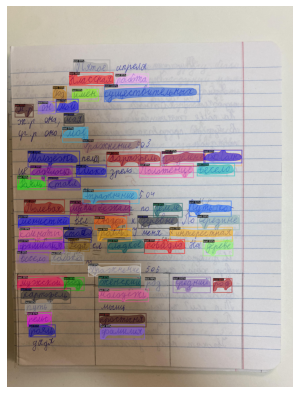

In [38]:
id_image_selected = 2
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7,7))
v = Visualizer(im[:, :],
              metadata=val_metadata, 
              scale=0.4 )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

В качестве предсказаний для каждого изображения из тестового набора требуется получить бинарную маску, в которой `1` означает, что данный пиксель относится к классу текста.

Давайте на примере одного изображения переведем формат выхода Detectron2 в требуемый формат для соревнования.

`outputs` - результат предсказания модели на данном изображении из предыдущего блока с кодом

In [39]:
prediction = outputs['instances'].pred_masks.cpu().numpy()

In [40]:
prediction.shape

(57, 4032, 3024)

В `prediction` находится массив бинарных матриц. Каждая матрица отвечает за отдельную задетектированную маску текста. В нашем случае модель задетектировала 80 текстовых масок. Давайте провизуализируем одну из них.

In [41]:
prediction[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

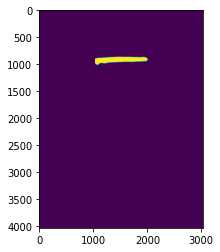

In [42]:
plt.imshow(prediction[0])

Отлично. Теперь, для того, чтобы получить бинарную маску со всем задетектированным текстом для изображения, нам нужно объединить все маски в одну. Для этого мы просто поэелементно сложим все наши матрицы. Там, где после сложения остались нули - модель не задетектировала никакого текста.

In [43]:
mask = np.add.reduce(prediction)

In [44]:
mask = mask > 0

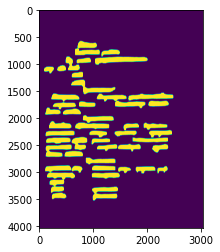

In [45]:
plt.imshow(mask)

Итак, нам нужно полуить такую маску для каждого изображения из валидационной выборки, а затем посчитать метрику F1-score.

In [46]:
#Подгрузим аннотации train
with open('train_segmentation/annotations_val.json') as f:
    annotations_val = json.load(f)

In [47]:
val_images = annotations_val['images']

In [48]:
val_predictions = {}

In [49]:
for val_img in tqdm.tqdm_notebook(val_images):
    file_name = val_img['file_name']
    img_path = os.path.join('train_segmentation/images/',file_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)
    prediction = outputs['instances'].pred_masks.cpu().numpy()
    mask = np.add.reduce(prediction)
    mask = mask > 0
    val_predictions[file_name] = mask

  0%|          | 0/78 [00:00<?, ?it/s]

In [50]:
val_predictions

{'1_0.JPG': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '1_12.JPG': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '5_0.JPG': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [Fa

Для сохрания предсказаний и загрузки бинарных масок бы будет использовать формат `.npz`. Он позволяет хранить большие массивы в компактном виде. Вот [ссылка](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html) на документацию.

In [51]:
np.savez_compressed('val_pred.npz',**val_predictions)

Подгрузим бинарные маски для train и val (только что сохраненную). Так как мы в начале бейзлайна разбивали весь исходный train на новый трейн и валидацию, то информация по всем маскам из исходного train хранится в `binary.npz`. 

Получившийся после подгрузки `np.load()` - что то вроде словаря. Его ключи можно получить с помощью метода files - `loaded_val.files`. В нашем случае ключами являются ключи исходного словаря `val_predictions`, то есть названия изображений.

In [53]:
loaded_train = np.load('train_segmentation/binary.npz')

In [54]:
loaded_val_pred = np.load('val_pred.npz')

Мы используем среднюю метрика F1-score. То есть считаем F1-score для каждого изображения, а затем усредняем результаты. 

Реализация из sklearn работает довольно долго, поэтому мы будем использовать свою.

In [55]:
def f1_loss(y_true, y_pred):
        
    
    tp = np.sum(y_true & y_pred)
    tn = np.sum(~y_true & ~y_pred)
    fp = np.sum(~y_true & y_pred)
    fn = np.sum(y_true & ~y_pred)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* precision*recall / ( precision + recall + epsilon)

    return f1 

In [56]:
f1_scores = []
for key in tqdm.tqdm_notebook(loaded_val_pred.files):
    pred = loaded_val_pred[key].reshape(-1)
    true = loaded_train[key].reshape(-1)
    
    f1_img = f1_loss(true,pred)
    f1_scores.append(f1_img)

  0%|          | 0/78 [00:00<?, ?it/s]

Получившаяся метрика на валидации.

In [58]:
np.mean(f1_scores)

0.6102213811897833

# Запись submission

Как уже говорилось ранее, правильные и предсказанные маски мы будем хранить в компактном формате `npz`. 

Возьмем нашу обученную модель и запишем предсказания в файл `prediction.npz`

In [59]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import Boxes, BoxMode 


In [60]:
def run(test_images_path,predictions_output_path):
    threshold = 0.5
    model_path = "./output/model_0002999.pth"
    
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) 
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.INPUT.MIN_SIZE_TEST= 300
    cfg.INPUT.MAX_SIZE_TEST = 300
    cfg.INPUT.FORMAT = 'BGR'
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    
    
    
    predictor = DefaultPredictor(cfg)
    results = {}
    
    
    for img in os.listdir(test_images_path):
        img_path = os.path.join(test_images_path,img)
        im = cv2.imread(img_path)
        outputs = predictor(im)
        prediction = outputs['instances'].pred_masks.cpu().numpy()
        mask = np.add.reduce(prediction)
        mask = mask > 0
        
        results[img] = mask  
    np.savez_compressed(predictions_output_path,**results)


В функцию передаем два аргумента:
* путь к папке с изображениями, на которых хотим сделать предсказания. сейчас это путь к валдиационными изображениям. Папку test мы положим во время запуска контейнера.
* путь к создаваемому файлу с предсказаниями. по время локального дебага можно использовать любое имя

Этот же код вынесен в отдельные скрипты для удобства, они должны запускаться во время запуска контейнера.

In [52]:
run('data/val/images','prediction.npz')

# Оценка качества.

Оценка качества на нашей стороне просходит по следующему скрипту - `evaluate.py`. Он принимает на вход путь к двум файлам формата `npz`. 
* `ref_path` - путь к файлу с правильными ответами 
* `pred_path` - путь к файлу с предсказаниями

Для начала сгенерируем файл формата `npz` для валидации.

In [53]:
val_true = {}
for i in loaded_train.files:
    if i in val_predictions.keys():
        val_true[i] = loaded_train[i]

In [54]:
np.savez_compressed('val_true.npz',**val_true)

In [ ]:
!python evaluate.py --ref_path val_true.npz --pred_path val_pred.npz